# Boston Dataset Analysis

Fits a Model to Boston Dataset (https://www.kaggle.com/c/boston-housing)

In [82]:
import timeit

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn import datasets
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn import neighbors
from sklearn import svm
from sklearn import tree
from sklearn import ensemble
        
seed = 16

In [83]:
# Some Helpful Functions

# Calculate VIF and drop colinear variables
from statsmodels.stats.outliers_influence import variance_inflation_factor    
def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped=True
    while dropped:
        dropped=False
        vif = [variance_inflation_factor(X.iloc[:,variables].values, ix) for ix in range(X.iloc[:,variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:,variables].columns[maxloc] + '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:,variables]

def run_estimators(estimators, X_train, y_train, X_test, y_test, scoring, cv=5, verbose=False):

    scores = []
    
    for clf in estimators:
        print("Running {0}...".format(clf.__class__.__name__))
        start_time = timeit.default_timer()
        clf.fit(X_train, y_train)
        elapsed = timeit.default_timer() - start_time
        print('Time Elapsed: ' + str(elapsed))
                
        test_scores = cross_val_score(clf, X_test, y_test, scoring=scoring, cv=cv)
        mean_test_cv_score = np.mean(test_scores)
        std_def_test_cv_score = np.std(test_scores)
        
        if verbose:
            train_scores = cross_val_score(clf, X_train, y_train, scoring=scoring, cv=cv)
            print("Mean Train CV Score: {0}".format(np.mean(train_scores)))
            print("Std. Dev. Train CV Score: {0}".format(np.std(train_scores)))
            print("Mean Test CV Score: {0}".format(mean_test_cv_score))
            print("Std. Dev. Test CV Score: {0}".format(std_dev_test_cv_score))  
        
        scores.append((clf.__class__.__name__ + " " + str(clf.get_params()), mean_test_cv_score, std_def_test_cv_score))
        
    return sorted(scores, key=lambda x: x[1], reverse=True)
        
        
def get_out_of_fold(model, X_train, y_train, X_test, k=5, random_state=42):
    """
    Gets Out-Of-Fold Predictions for a model
    
    Parameters
    ----------
    model : list of pandas.DataFrame
        Model to get Out-Of-Fold predictions for
    X_train : numpy.ndarray or pandas.DataFrame
        Features of Training Set
    y_train : numpy.ndarray or pandas.DataFrame
        Target of Training Set
    X_test : numpy.ndarray or pandas.DataFrame
        Featrues of Testing Set
    k : int
        Number of folds
    random_state : int
        The seed of the pseudo random number generator to use when shuffling the data.
        
    Returns
    -------
    numpy.array
        Out-Of-Fold X Train
    numpy.array
        Out-Of-Fold X Test
        
    Raises
    ------
    TypeError
        when X_train, y_train, or X_test isn't a Numpy ndarray or a Pandas DataFrame
    """
    # Check Input
    if (not isinstance(X_train, (np.ndarray, pd.Series, pd.DataFrame))
            or not isinstance(y_train, (np.ndarray, pd.Series, pd.DataFrame))
            or not isinstance(X_test, (np.ndarray, pd.Series, pd.DataFrame))):
        raise TypeError('Input Data must be either a Numpy ndarray, Pandas Series, or Pandas DataFrame')
    
    # Convert to Numpy Array
    if isinstance(X_train, (pd.Series, pd.DataFrame)):
        X_train = X_train.values
    if isinstance(y_train, (pd.Series, pd.DataFrame)):
        y_train = y_train.values
    if isinstance(X_test, (pd.Series, pd.DataFrame)):
        X_test = X_test.values
    
    # Create Folds
    kf = KFold(n_splits=k, random_state=random_state)
    
    # Init oof predictions arrays
    oof_train = np.zeros((len(X_train),))
    oof_test = np.zeros((len(X_test),))
    
    # Create matrix to hold X_test predictions across folds
    # The oof esimations you apply to train, you need to apply to X_test as well. 
    oof_test_folds = np.empty((k, len(X_test)))
    
    # For each fold, create predictions on the out fold (out-of-fold predictions)
    for i, (train_idx, test_idx) in enumerate(kf.split(X_train, y_train)):
        # Train on "in-folds"
        X_in_folds = X_train[train_idx]
        y_in_folds = y_train[train_idx]
        
        # Predict "Out Folds"
        X_out_fold = X_train[test_idx]
        
        # Fit Model
        model.fit(X_in_folds, y_in_folds)
        
        # Make Out-Of-Fold Predictions
        oof_train[test_idx] = model.predict(X_out_fold)
        oof_test_folds[i, :] = model.predict(X_test)
        
    # Take the mean of test across all folds    
    oof_test[:] = oof_test_folds.mean(axis=0)
    
    # Return new X_train, and X_test as numpy arrays for the model. 
    return oof_train, oof_test


def stack(models, X_train, y_train, X_test, k=5, random_state=42):
    """
    Gets Out-Of-Fold predictions for a list of models
    
    Parameters
    ----------
    models : list of pandas.core.frame.DataFrame
        List of models to stack
    X_train : pandas.core.frame.DataFrame
        Features of Training Set
    y_train : pandas.core.frame.DataFrame
        Target of Training Set
    X_test : pandas.core.frame.DataFrame
        Featrues of Testing Set
    k : int
        Number of folds
    random_state : int
        The seed of the pseudo random number generator to use when shuffling the data.
    
    Returns
    -------
    pandas.core.frame.DataFrame
        DataFrame of the predictions of each of the models
    """
    # Init stacked dicts
    X_train_stacked = {}
    X_test_stacked = {}
    
    # for each model, create out of fold predictions 
    for i, model in enumerate(models):
        X_train_oof, X_test_oof = get_out_of_fold(model, X_train, y_train, X_test, k=k, random_state=random_state)
        
        X_train_stacked[f'model_{i+1}'] = X_train_oof
        X_test_stacked[f'model_{i+1}'] = X_test_oof
        
    return pd.DataFrame(X_train_stacked), pd.DataFrame(X_test_stacked)

In [84]:
# Load Boston Dataset
boston = datasets.load_boston()
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['target'] = boston.target

In [85]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


## EDA

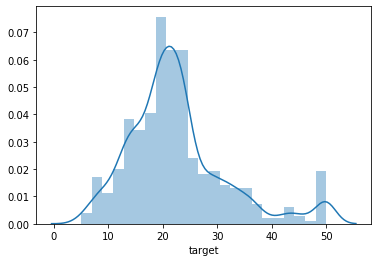

In [86]:
# Get a sense of our target variable (House prices in $1000's)

sns.distplot(df['target']);

Target variable is decidedly non-normal, but let's check anyways.

In [87]:
k2, p = stats.normaltest(df['target'])
alpha = 0.05
print("p = {:g}".format(p))

if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected. Not a Normal Distribution.")
else:
    print("The null hypothesis cannot be rejected. May be a Normal Distribution.")

p = 1.75832e-20
The null hypothesis can be rejected. Not a Normal Distribution.


In [88]:
print("Skewness: %f" % df['target'].skew())
print("Kurtosis: %f" % df['target'].kurt())

Skewness: 1.108098
Kurtosis: 1.495197


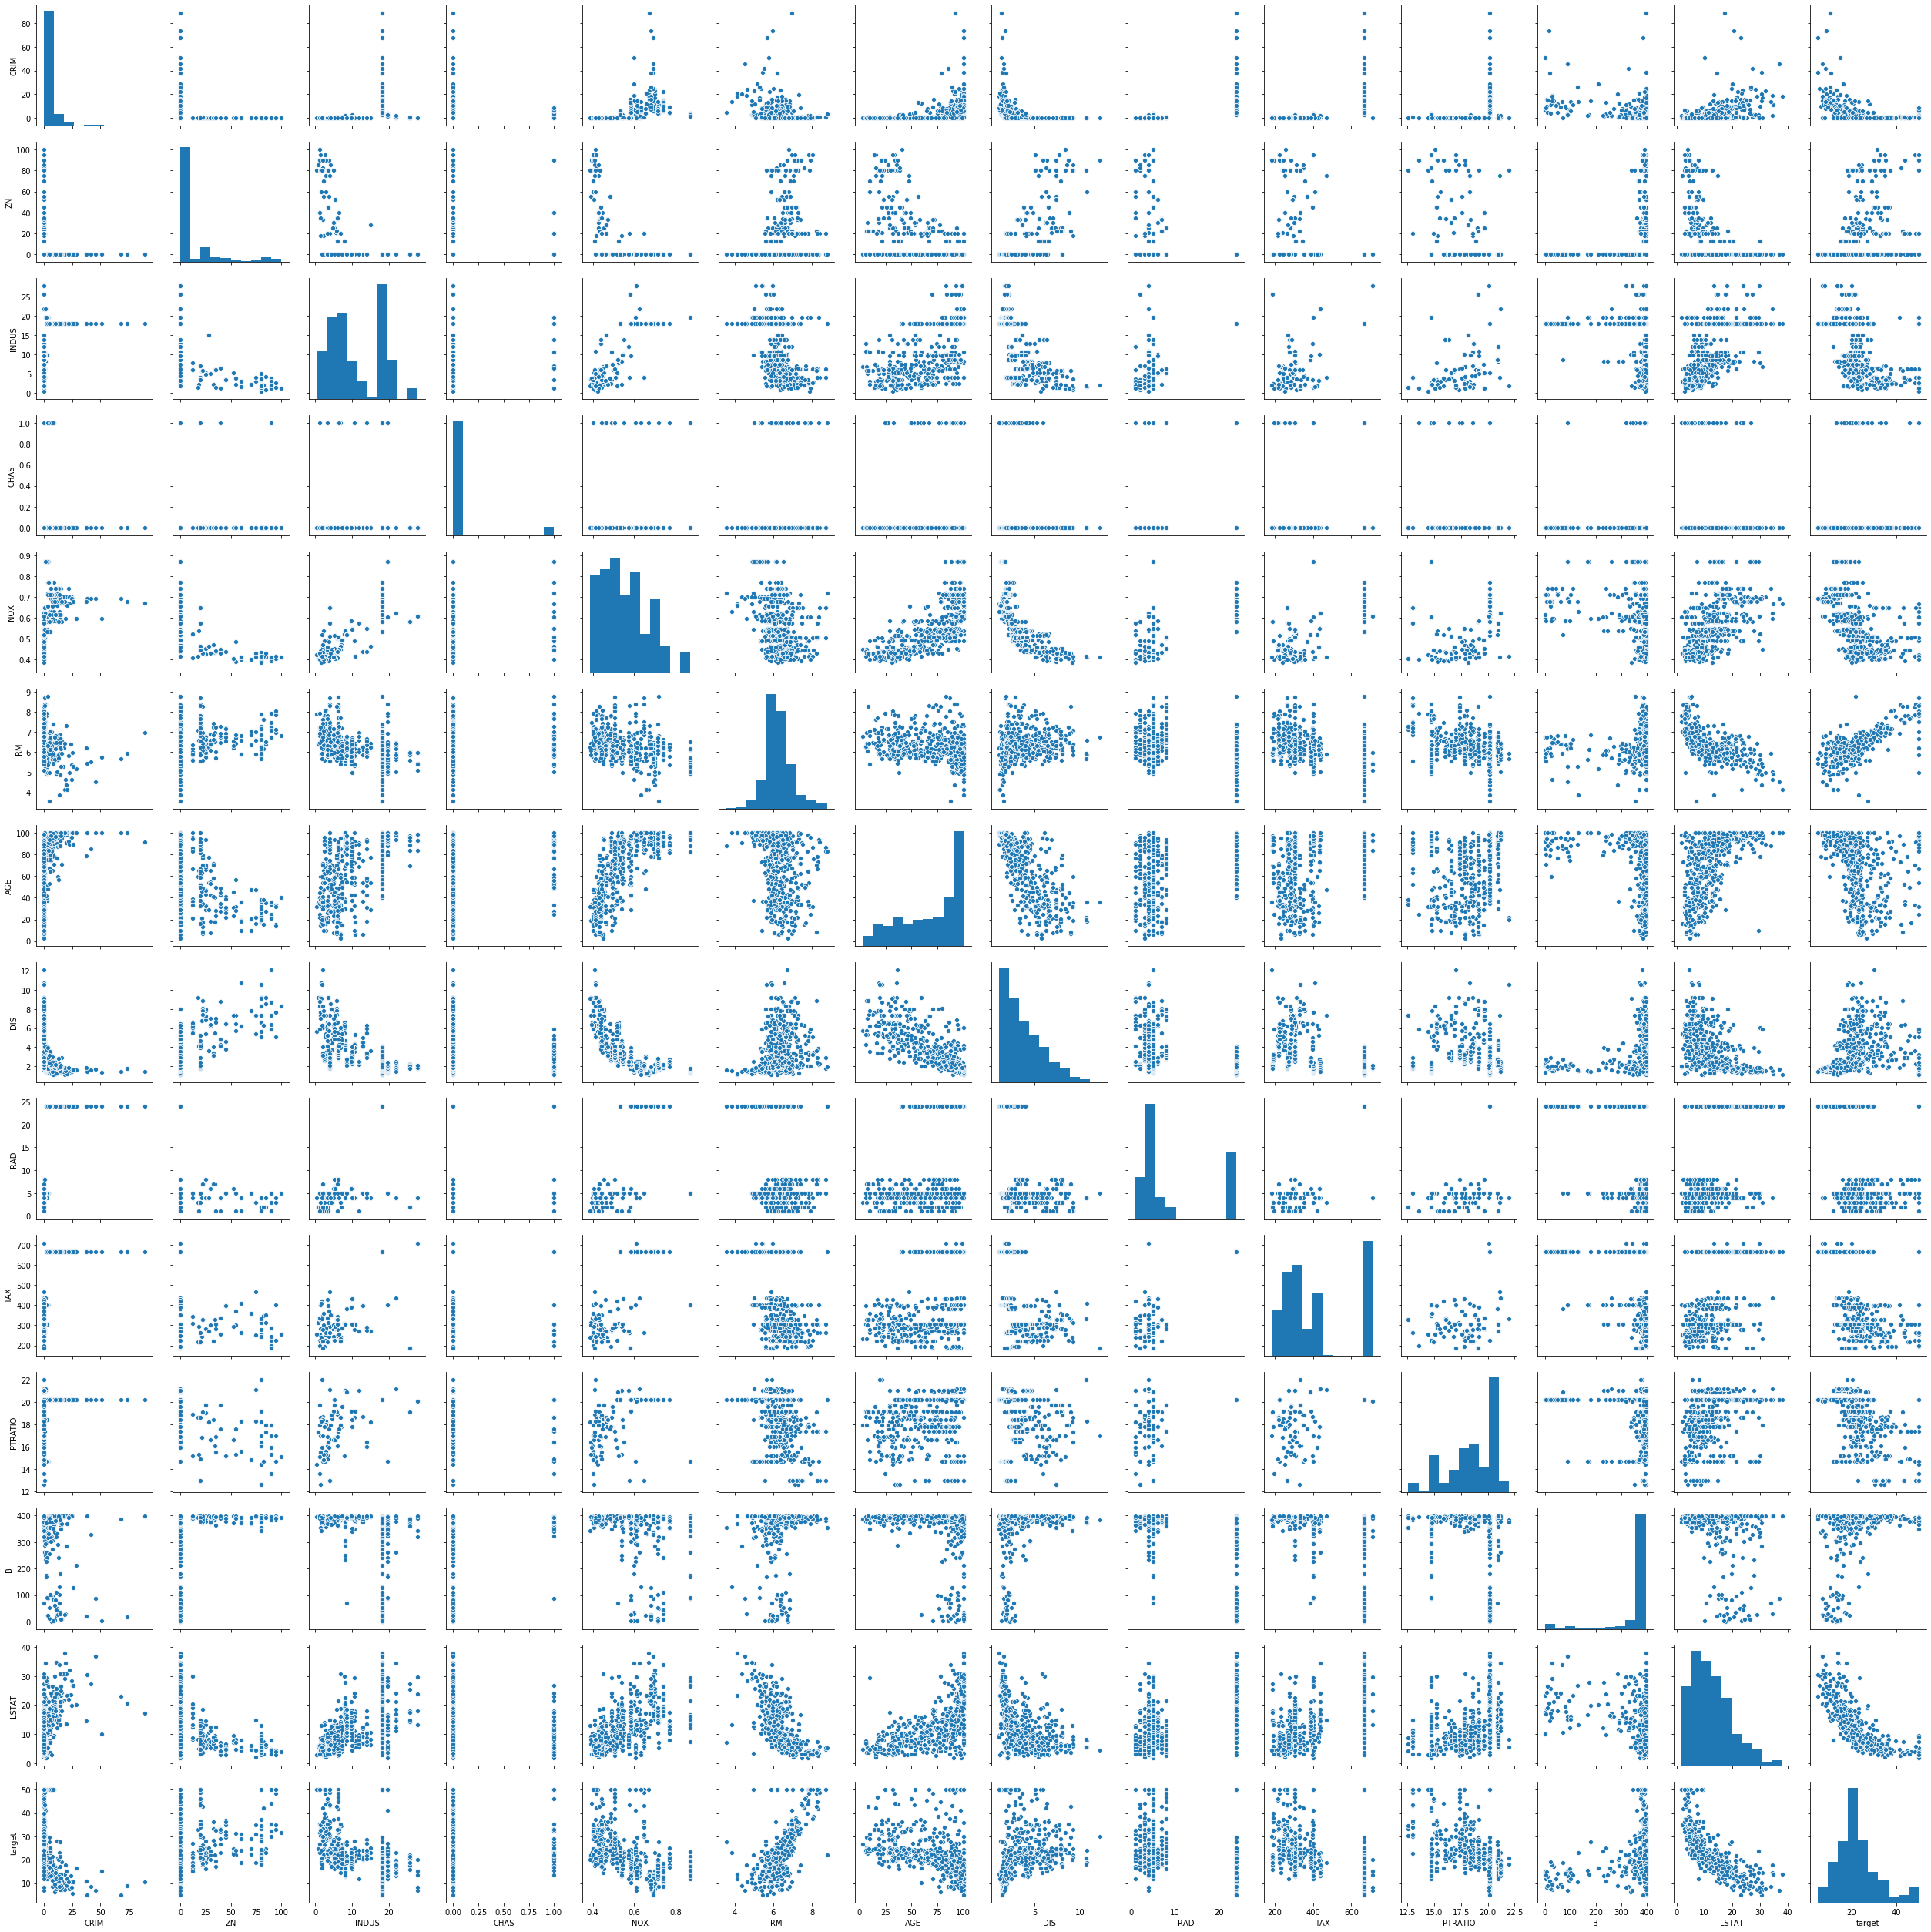

In [89]:
# Pair Plot
sns.pairplot(df)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6a8bc75278>,
      dtype=object)

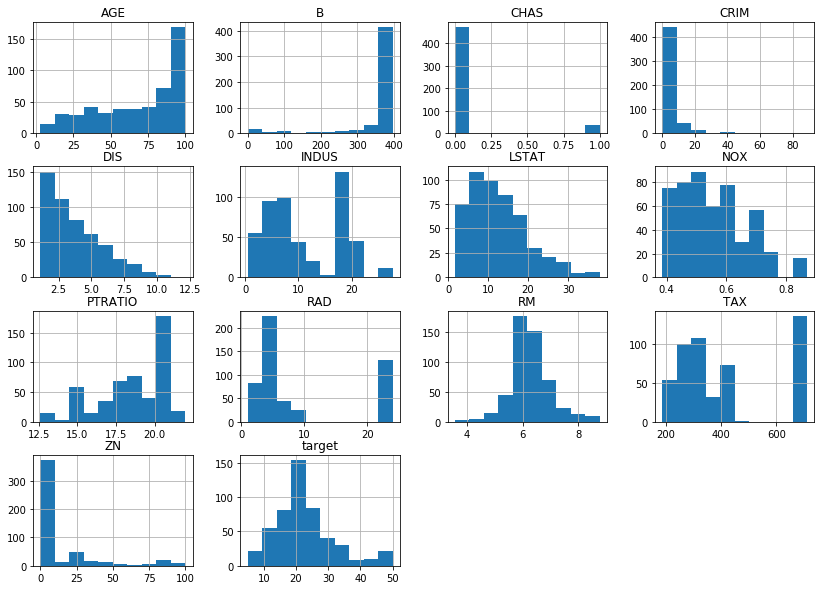

In [90]:
df.hist(figsize=(14,10))

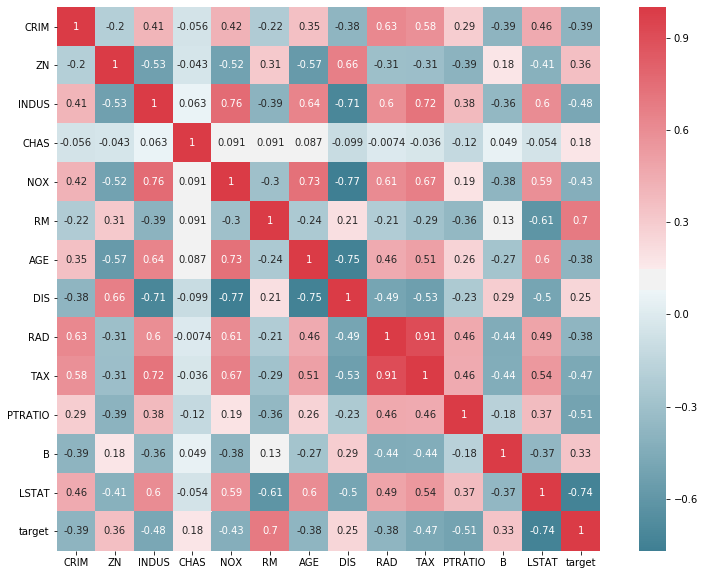

In [91]:
# Correlation Map

f, ax = plt.subplots(figsize=(14, 10))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True)

In [92]:
# Detect Multicollinearity
# range from 0 (Perfect Collinearity) to 1 (No Collinearity)

# Compare the determinant
print(np.linalg.det(corr)) 

3.445683426441398e-05


## Data Correct and Clean

In [93]:
# Missing Values Check
# Generally throw away columns that are missing more than 15%

total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data)

         Total  Percent
target       0      0.0
LSTAT        0      0.0
B            0      0.0
PTRATIO      0      0.0
TAX          0      0.0
RAD          0      0.0
DIS          0      0.0
AGE          0      0.0
RM           0      0.0
NOX          0      0.0
CHAS         0      0.0
INDUS        0      0.0
ZN           0      0.0
CRIM         0      0.0


## Preprocess

In [94]:
y = df['target']
X = df.drop(['target'], axis=1)

In [95]:
# Standardize
# Standardization is required for L1 and L2 Regularization, SVMs, and PCA (More or less any algorithm based on distance)
col_names = X.columns
X = pd.DataFrame(StandardScaler().fit_transform(X), columns=col_names)

# Drop colinear Variables
X = calculate_vif_(X)
# Compare the determinant to previous
print(np.linalg.det(X.corr())) 

X.head()

dropping 'TAX' at index: 9
Remaining variables:
Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')
0.0011968284963619188


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,PTRATIO,B,LSTAT
0,-0.419782,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-1.459000,0.441052,-1.075562
1,-0.417339,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.303094,0.441052,-0.492439
2,-0.417342,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.303094,0.396427,-1.208727
3,-0.416750,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,0.113032,0.416163,-1.361517
4,-0.412482,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,0.113032,0.441052,-1.026501


In [96]:
# Test, Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

## Model Selection

Start from simple to complex

Linear Models -> Support Vectors -> Trees -> Ensembles, Boosting, Bagging, Etc. -> Stacked Models

In [97]:
# Regression
clfs =[
    # Linear Models
    linear_model.LinearRegression(),
    linear_model.Ridge(random_state=seed),
    linear_model.BayesianRidge(),
    linear_model.Lasso(random_state=seed),
    linear_model.LassoLars(),
    linear_model.Lars(),
    linear_model.ElasticNet(random_state=seed),
    linear_model.ARDRegression(),
    linear_model.PassiveAggressiveRegressor(max_iter=1000, tol=1e-3, random_state=seed), # 0.21 defaults
    linear_model.RANSACRegressor(random_state=seed),
    linear_model.SGDRegressor(max_iter=1000, tol=1e-3, random_state=seed),  # 0.21 defaults
    linear_model.TheilSenRegressor(max_iter=1000, tol=1e-3, random_state=seed),  # 0.21 defaults
    # K-Neighbors
    neighbors.KNeighborsRegressor(n_neighbors = 1),
    neighbors.KNeighborsRegressor(n_neighbors = 2),
    neighbors.KNeighborsRegressor(n_neighbors = 4),
    neighbors.KNeighborsRegressor(n_neighbors = 8),
    neighbors.KNeighborsRegressor(n_neighbors = 16),
    neighbors.KNeighborsRegressor(n_neighbors = 32),
    neighbors.KNeighborsRegressor(n_neighbors = 64),
    # Support Vector Machines
    svm.LinearSVR(random_state=seed), #liblinear
    svm.NuSVR(),
    svm.SVR(kernel="linear"), #libsvm
    svm.SVR(kernel="sigmoid"),
    svm.SVR(kernel="rbf"),
    # Tree (CART)
    tree.DecisionTreeRegressor(random_state=seed),
    tree.ExtraTreeRegressor(random_state=seed),
    # Ensemble Methods
    ensemble.AdaBoostRegressor(random_state=seed),
    ensemble.BaggingRegressor(random_state=seed),
    ensemble.ExtraTreesRegressor(random_state=seed),
    ensemble.IsolationForest(random_state=seed),
    ensemble.GradientBoostingRegressor(random_state=seed),
    ensemble.RandomForestRegressor(random_state=seed)
    #TODO State of the art models - e.g. XGBoost
]

scores = run_estimators(clfs, X_train, y_train, X_test, y_test, scoring="neg_mean_squared_error")

print("\nBest Scores:")
for s in scores:
    print("{0}\n{1} (+/- {2})".format(s[0], s[1], s[2]))

Running LinearRegression...
Time Elapsed: 0.0015078950000315672
Running Ridge...
Time Elapsed: 0.0011737720014934894
Running BayesianRidge...
Time Elapsed: 0.0011297219989501173
Running Lasso...
Time Elapsed: 0.0008573910017730668
Running LassoLars...
Time Elapsed: 0.0008134990002872655
Running Lars...
Time Elapsed: 0.0022315599999274127
Running ElasticNet...
Time Elapsed: 0.0009180170000036014
Running ARDRegression...
Time Elapsed: 0.13262883499919553
Running PassiveAggressiveRegressor...
Time Elapsed: 0.0009548760008328827
Running RANSACRegressor...
Time Elapsed: 0.04306325400102651
Running SGDRegressor...
Time Elapsed: 0.0012183869985165074
Running TheilSenRegressor...
Time Elapsed: 0.7478803079993668
Running KNeighborsRegressor...
Time Elapsed: 0.000738591001208988
Running KNeighborsRegressor...
Time Elapsed: 0.000602565000008326
Running KNeighborsRegressor...
Time Elapsed: 0.0005276430001686094
Running KNeighborsRegressor...
Time Elapsed: 0.0005975309995847056
Running KNeighborsRe

/opt/anaconda/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: 

Time Elapsed: 0.042529398000624496
Running BaggingRegressor...
Time Elapsed: 0.013214412998422631
Running ExtraTreesRegressor...
Time Elapsed: 0.00846638700022595
Running IsolationForest...
Time Elapsed: 0.07987295200109656


/opt/anaconda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/opt/anaconda/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/opt/anaconda/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/opt/anaconda/lib/pytho

Running GradientBoostingRegressor...
Time Elapsed: 0.027088561000709888
Running RandomForestRegressor...
Time Elapsed: 0.01226527299877489

Best Scores:
GradientBoostingRegressor {'alpha': 0.9, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'presort': 'auto', 'random_state': 16, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
-11.533371327617367 (+/- 3.418265299350505)
ExtraTreesRegressor {'bootstrap': False, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None,

/opt/anaconda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [98]:
# Look at feature importances of trees
# Importances > 0.1
# Extra Trees: RM, LSTAT
# Gradient Boosting: RM, LSTAT, DIS, INDUS, CRIM (Close .094)
# AdaBoost: LSTAT, RM, DIS
# Random Forest: RM, LSTAT

tr = ensemble.GradientBoostingRegressor(random_state=seed)
tr.fit(X_train, y_train)
fi_tr = sorted(list(zip(X_train.columns, tr.feature_importances_)), key=lambda x: x[1], reverse=True)

print(tr.__class__.__name__)
for fi in fi_tr:
    print("{0} - {1}".format(fi[0], fi[1]))

GradientBoostingRegressor
RM - 0.4769959347111267
LSTAT - 0.3085508573501948
DIS - 0.10049866734116247
PTRATIO - 0.03695133799921325
CRIM - 0.0251401952432209
B - 0.0145837614888946
NOX - 0.013642774418212445
INDUS - 0.009672756323688856
AGE - 0.007026690697848504
RAD - 0.004290950049259385
CHAS - 0.0024456585265298296
ZN - 0.00020041585064836827


### Tune Best Models

We tune ExtraTrees and GradientBoosting.

In [99]:
et = ensemble.ExtraTreesRegressor()

param_grid = { 
           "n_estimators" : [9, 18, 27, 36, 45, 54, 63],
           "max_depth" : [1, 5, 10, 15, 20, 25, 30],
           "min_samples_leaf" : [1, 2, 4, 6, 8, 10]}
clf = GridSearchCV(et, param_grid,cv=5, scoring="neg_mean_squared_error")
clf.fit(X_train, y_train)

print("Best parameters set found on train set:")
print()
print(clf.best_params_)
print()
print("Grid scores on train set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Best parameters set found on train set:

{'max_depth': 30, 'min_samples_leaf': 1, 'n_estimators': 54}

Grid scores on train set:

-51.891 (+/-21.958) for {'max_depth': 1, 'min_samples_leaf': 1, 'n_estimators': 9}
-51.347 (+/-29.617) for {'max_depth': 1, 'min_samples_leaf': 1, 'n_estimators': 18}
-52.800 (+/-32.212) for {'max_depth': 1, 'min_samples_leaf': 1, 'n_estimators': 27}
-50.761 (+/-31.195) for {'max_depth': 1, 'min_samples_leaf': 1, 'n_estimators': 36}
-51.170 (+/-24.949) for {'max_depth': 1, 'min_samples_leaf': 1, 'n_estimators': 45}
-51.720 (+/-28.219) for {'max_depth': 1, 'min_samples_leaf': 1, 'n_estimators': 54}
-50.422 (+/-27.366) for {'max_depth': 1, 'min_samples_leaf': 1, 'n_estimators': 63}
-47.925 (+/-29.031) for {'max_depth': 1, 'min_samples_leaf': 2, 'n_estimators': 9}
-49.823 (+/-27.004) for {'max_depth': 1, 'min_samples_leaf': 2, 'n_estimators': 18}
-54.766 (+/-34.435) for {'max_depth': 1, 'min_samples_leaf': 2, 'n_estimators': 27}
-50.933 (+/-26.606) for {'max_de

/opt/anaconda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [100]:
gb = ensemble.GradientBoostingRegressor()

param_grid = { 
           "n_estimators" : [100, 150, 200, 300, 500, 1000],
           "min_samples_leaf" : [1, 2, 4, 6, 8, 10]}
clf = GridSearchCV(gb, param_grid,cv=5, scoring="neg_mean_squared_error")
clf.fit(X_train, y_train)

print("Best parameters set found on train set:")
print()
print(clf.best_params_)
print()
print("Grid scores on train set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Best parameters set found on train set:

{'min_samples_leaf': 4, 'n_estimators': 100}

Grid scores on train set:

-14.411 (+/-16.098) for {'min_samples_leaf': 1, 'n_estimators': 100}
-14.104 (+/-15.376) for {'min_samples_leaf': 1, 'n_estimators': 150}
-14.142 (+/-15.347) for {'min_samples_leaf': 1, 'n_estimators': 200}
-14.236 (+/-15.189) for {'min_samples_leaf': 1, 'n_estimators': 300}
-14.394 (+/-15.353) for {'min_samples_leaf': 1, 'n_estimators': 500}
-14.741 (+/-14.904) for {'min_samples_leaf': 1, 'n_estimators': 1000}
-14.759 (+/-17.600) for {'min_samples_leaf': 2, 'n_estimators': 100}
-15.022 (+/-18.177) for {'min_samples_leaf': 2, 'n_estimators': 150}
-14.569 (+/-16.721) for {'min_samples_leaf': 2, 'n_estimators': 200}
-14.778 (+/-17.572) for {'min_samples_leaf': 2, 'n_estimators': 300}
-15.141 (+/-17.950) for {'min_samples_leaf': 2, 'n_estimators': 500}
-14.694 (+/-16.450) for {'min_samples_leaf': 2, 'n_estimators': 1000}
-12.666 (+/-8.150) for {'min_samples_leaf': 4, 'n_estima

/opt/anaconda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## Ensemble Stack Models

In [101]:
clfs = [
    ensemble.ExtraTreesRegressor(max_depth=15, min_samples_leaf=1, n_estimators=27, random_state=seed),
    ensemble.GradientBoostingRegressor(min_samples_leaf=4, n_estimators=100, random_state=seed),
]

X_train_2, X_test_2 = stack(clfs, X_train, y_train, X_test)

stacker = linear_model.LinearRegression()
stacker.fit(X_train_2, y_train)
scores = np.sqrt(cross_val_score(stacker, X_test_2, y_test, scoring='neg_mean_squared_error', cv=5) * -1)

print("Mean RMSE: {0}, Std. Dev. RMSE: {1}".format(np.mean(scores), np.std(scores)))

Mean RMSE: 2.9140916520892244, Std. Dev. RMSE: 0.2951079753746388


In [102]:
# Test Stacked for best model

# Regression
clfs =[
    # Linear Models
    linear_model.LinearRegression(),
    linear_model.Ridge(random_state=seed),
    linear_model.BayesianRidge(),
    linear_model.Lasso(random_state=seed),
    linear_model.LassoLars(),
    linear_model.Lars(),
    linear_model.ElasticNet(random_state=seed),
    linear_model.ARDRegression(),
    linear_model.PassiveAggressiveRegressor(max_iter=1000, tol=1e-3, random_state=seed), # 0.21 defaults
    linear_model.RANSACRegressor(random_state=seed),
    linear_model.SGDRegressor(max_iter=1000, tol=1e-3, random_state=seed),  # 0.21 defaults
    linear_model.TheilSenRegressor(max_iter=1000, tol=1e-3, random_state=seed),  # 0.21 defaults
    # K-Neighbors
    neighbors.KNeighborsRegressor(n_neighbors = 1),
    neighbors.KNeighborsRegressor(n_neighbors = 2),
    neighbors.KNeighborsRegressor(n_neighbors = 4),
    neighbors.KNeighborsRegressor(n_neighbors = 8),
    neighbors.KNeighborsRegressor(n_neighbors = 16),
    neighbors.KNeighborsRegressor(n_neighbors = 32),
    neighbors.KNeighborsRegressor(n_neighbors = 64),
    # Support Vector Machines
    svm.LinearSVR(random_state=seed), #liblinear
    svm.NuSVR(),
    svm.SVR(kernel="linear"), #libsvm
    svm.SVR(kernel="sigmoid"),
    svm.SVR(kernel="rbf"),
    # Tree (CART)
    tree.DecisionTreeRegressor(random_state=seed),
    tree.ExtraTreeRegressor(random_state=seed),
    # Ensemble Methods
    ensemble.AdaBoostRegressor(random_state=seed),
    ensemble.BaggingRegressor(random_state=seed),
    ensemble.ExtraTreesRegressor(random_state=seed),
    ensemble.IsolationForest(random_state=seed),
    ensemble.GradientBoostingRegressor(random_state=seed),
    ensemble.RandomForestRegressor(random_state=seed)
    #TODO State of the art models - e.g. XGBoost
]

scores = run_estimators(clfs, X_train_2, y_train, X_test_2, y_test, scoring="neg_mean_squared_error")

print("\nBest Scores:")
for s in scores:
    print("{0}\n{1} (+/- {2})".format(s[0], s[1], s[2]))

Running LinearRegression...
Time Elapsed: 0.0010872379989450565
Running Ridge...
Time Elapsed: 0.0009575389995006844
Running BayesianRidge...
Time Elapsed: 0.0010995840002578916
Running Lasso...
Time Elapsed: 0.0009834690008574398
Running LassoLars...
Time Elapsed: 0.0009199840005749138
Running Lars...
Time Elapsed: 0.0010205920007138047
Running ElasticNet...
Time Elapsed: 0.0007902889992692508
Running ARDRegression...
Time Elapsed: 0.03826749600011681
Running PassiveAggressiveRegressor...
Time Elapsed: 0.0007814099990355317
Running RANSACRegressor...
Time Elapsed: 0.0037900380011706147
Running SGDRegressor...
Time Elapsed: 0.0016485739997733617
Running TheilSenRegressor...
Time Elapsed: 0.5796403700005612
Running KNeighborsRegressor...
Time Elapsed: 0.0006083919997763587
Running KNeighborsRegressor...
Time Elapsed: 0.0005782669995824108
Running KNeighborsRegressor...
Time Elapsed: 0.000658349999866914
Running KNeighborsRegressor...
Time Elapsed: 0.0005880099997739308
Running KNeighbor

/opt/anaconda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", Conve

Running DecisionTreeRegressor...
Time Elapsed: 0.0010245209996355698
Running ExtraTreeRegressor...
Time Elapsed: 0.0007777969985909294
Running AdaBoostRegressor...
Time Elapsed: 0.029738250999798765
Running BaggingRegressor...
Time Elapsed: 0.006845023999630939
Running ExtraTreesRegressor...
Time Elapsed: 0.005091188999358565
Running IsolationForest...
Time Elapsed: 0.07844564700099


/opt/anaconda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/opt/anaconda/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/opt/anaconda/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/opt/anaconda/lib/pytho

Running GradientBoostingRegressor...
Time Elapsed: 0.014668939000330283
Running RandomForestRegressor...
Time Elapsed: 0.00641441500010842

Best Scores:
TheilSenRegressor {'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'max_subpopulation': 10000, 'n_jobs': None, 'n_subsamples': None, 'random_state': 16, 'tol': 0.001, 'verbose': False}
-8.430314697411555 (+/- 1.6755883949112398)
ARDRegression {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'compute_score': False, 'copy_X': True, 'fit_intercept': True, 'lambda_1': 1e-06, 'lambda_2': 1e-06, 'n_iter': 300, 'normalize': False, 'threshold_lambda': 10000.0, 'tol': 0.001, 'verbose': False}
-8.452804895192624 (+/- 1.7619203422424434)
SVR {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'auto_deprecated', 'kernel': 'linear', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
-8.45426062526087 (+/- 1.6806165459902191)
Lasso {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'nor

/opt/anaconda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [103]:
stacker = linear_model.TheilSenRegressor(max_iter=1000, tol=1e-3, random_state=seed)
stacker.fit(X_train_2, y_train)
scores = np.sqrt(cross_val_score(stacker, X_test_2, y_test, scoring='neg_mean_squared_error', cv=5) * -1)
y_pred = cross_val_predict(stacker, X_test_2, y_test, cv=5)

print("Mean RMSE: {0}, Std. Dev. RMSE: {1}".format(np.mean(scores), np.std(scores)))

Mean RMSE: 2.8898475834406483, Std. Dev. RMSE: 0.28123947428090085


In [104]:
X_train_2.head()

,model_1,model_2
0,44.974074,44.293893
1,19.702346,20.441244
2,15.385185,14.707521
3,30.503086,30.236689
4,20.984568,21.193589


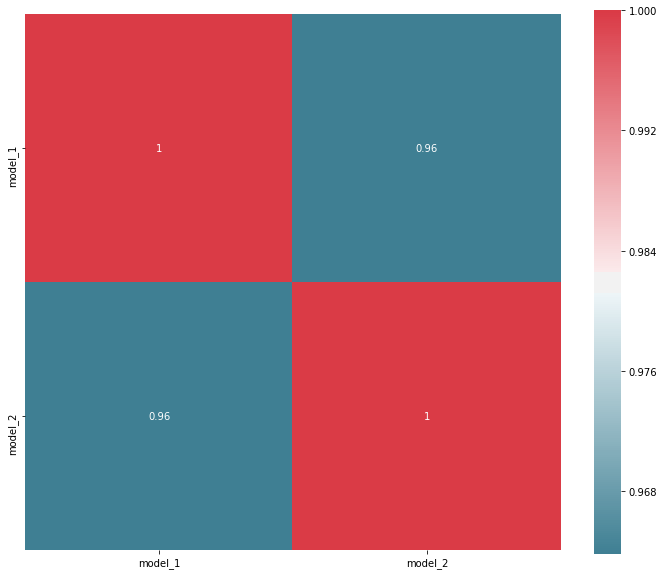

In [105]:
f, ax = plt.subplots(figsize=(12, 10))
corr = X_train_2.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True)

There have been quite a few articles and Kaggle competition winner stories about the merits of having trained models that are more uncorrelated with one another producing better scores.

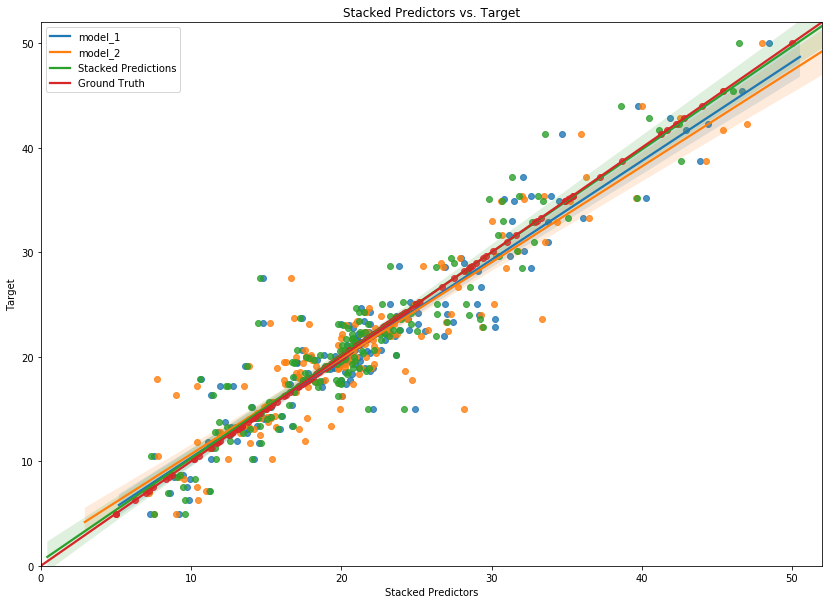

In [107]:
plt.figure(figsize=(14,10))

sns.regplot(x=X_test_2['model_1'], y=y_test)
sns.regplot(x=X_test_2['model_2'], y=y_test)
sns.regplot(x=y_pred, y=y_test) # Stacked Predictions
ax = sns.regplot(x=y_test, y=y_test) # Ground Truth

cols = list(X_test_2.columns)
cols.append("Stacked Predictions")
cols.append("Ground Truth")

ax.set(xlabel='Stacked Predictors', ylabel='Target', title='Stacked Predictors vs. Target')
ax.legend(cols)
plt.ylim(0, 52)
plt.xlim(0, 52)
plt.show()

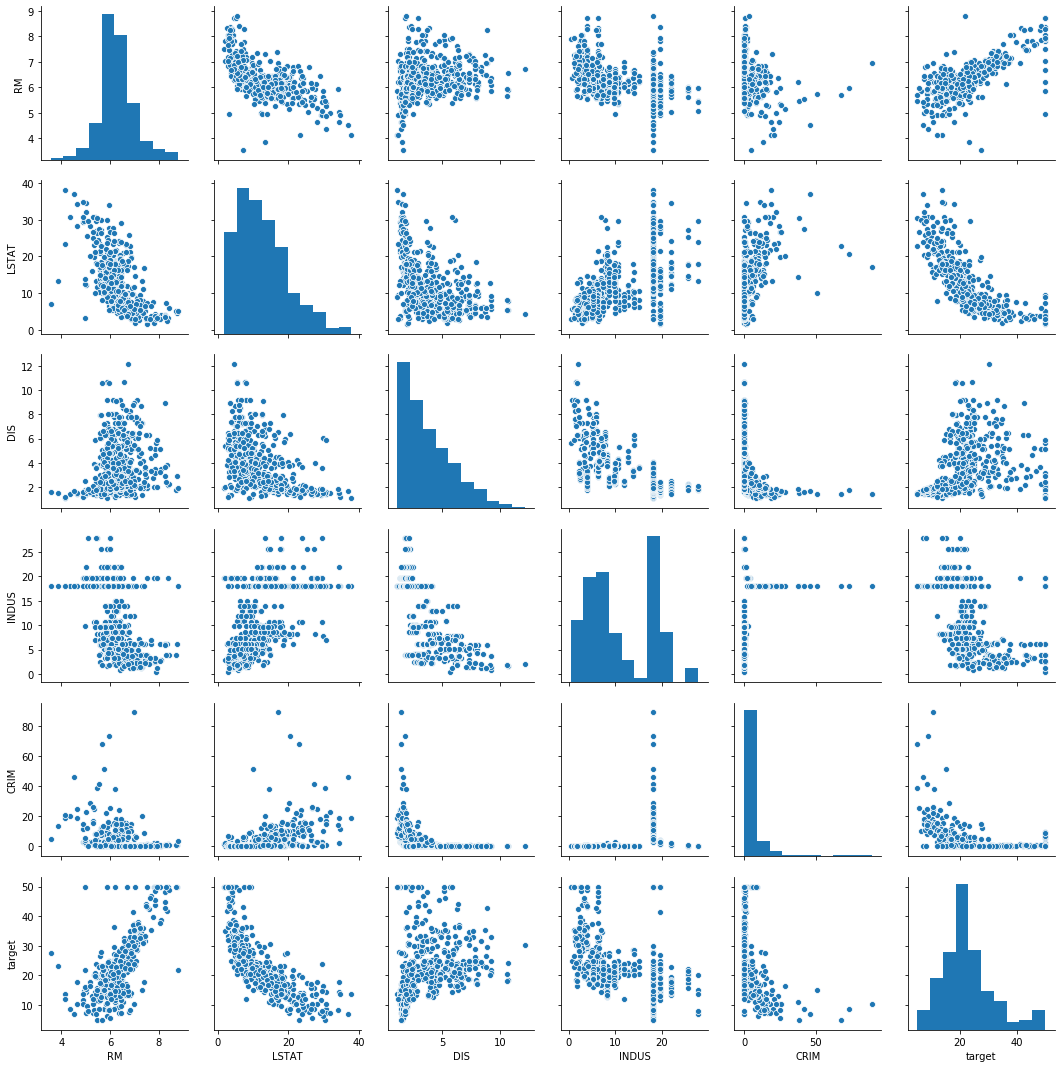

In [108]:
# Let's do a little inference in important features from Gradient Boosting

sns.pairplot(df[['RM', 'LSTAT', 'DIS', 'INDUS', 'CRIM', 'target']])